# Evaluation of models

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X_train = pd.read_csv("../data/processed/X_train.csv")
X_val = pd.read_csv("../data/processed/X_val.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
y_val = pd.read_csv("../data/processed/y_val.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

target_variable = "tree_type"

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(max_depth=10, n_estimators=10),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gaussian NB": GaussianNB(),
    "Bernoulli NB": BernoulliNB(),
}

# Fit models
for name, model in models.items():
    model.fit(X_train, y_train[target_variable])

## Classification Metrics Foundation: Beyond Accuracy

Concept: Accuracy tells you "how often you're right" but hides crucial details about different types of errors. Understanding precision, recall, and F1-score reveals exactly where your model succeeds and fails.

In [10]:
def basic_metrics(model, X_test, y_test):
    """Calculate fundamental classification metrics"""
    y_pred = model.predict(X_test)
    
    # Get confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")  
    print(f"F1-Score:  {f1:.3f}")
    
    return accuracy, precision, recall, f1

# Print evaluation metrics for each model
for name, model in models.items():
    print(f"\n{name} Evaluation:")
    basic_metrics(model, X_test, y_test[target_variable])


Logistic Regression Evaluation:
Accuracy:  0.837
Precision: 0.814
Recall:    0.830
F1-Score:  0.822

Decision Tree Evaluation:
Accuracy:  0.869
Precision: 0.851
Recall:    0.861
F1-Score:  0.856

Random Forest Evaluation:
Accuracy:  0.891
Precision: 0.871
Recall:    0.890
F1-Score:  0.881

SVM Evaluation:
Accuracy:  0.865
Precision: 0.832
Recall:    0.878
F1-Score:  0.855

KNN Evaluation:
Accuracy:  0.906
Precision: 0.886
Recall:    0.909
F1-Score:  0.897

Gaussian NB Evaluation:
Accuracy:  0.712
Precision: 0.688
Recall:    0.668
F1-Score:  0.678

Bernoulli NB Evaluation:
Accuracy:  0.758
Precision: 0.717
Recall:    0.771
F1-Score:  0.743


## Confusion Matrix: Your Model's Report Card

Concept: The confusion matrix is your model's detailed report card, showing exactly which classes get confused with which others. This visual tool reveals patterns that single metrics miss.


Logistic Regression Confusion Matrix:


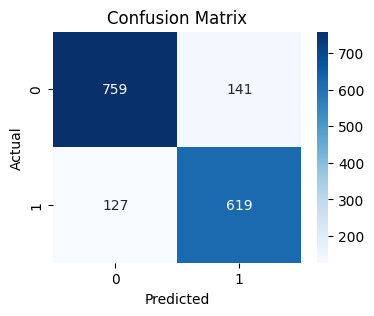

Total samples: 1646
Accuracy: 0.837

Decision Tree Confusion Matrix:


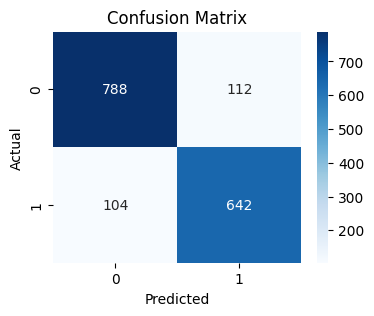

Total samples: 1646
Accuracy: 0.869

Random Forest Confusion Matrix:


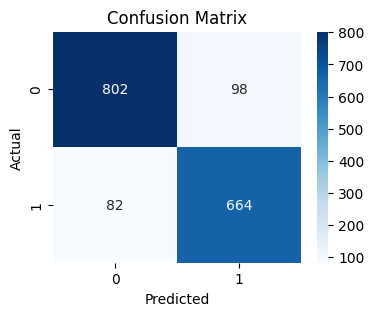

Total samples: 1646
Accuracy: 0.891

SVM Confusion Matrix:


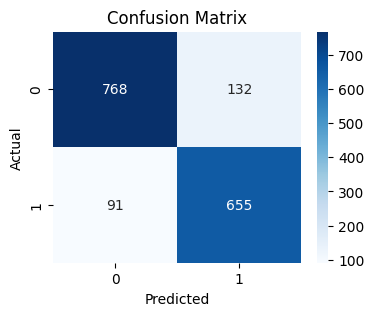

Total samples: 1646
Accuracy: 0.865

KNN Confusion Matrix:


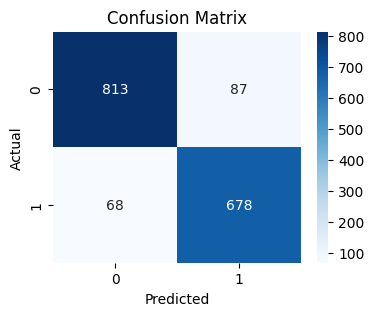

Total samples: 1646
Accuracy: 0.906

Gaussian NB Confusion Matrix:


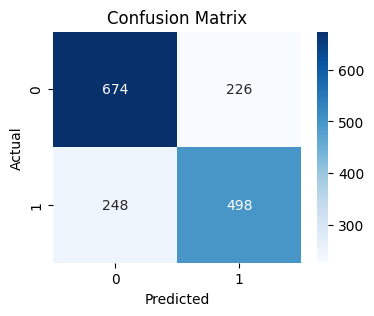

Total samples: 1646
Accuracy: 0.712

Bernoulli NB Confusion Matrix:


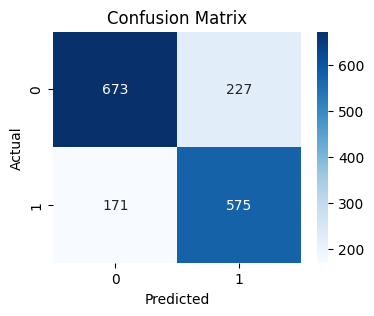

Total samples: 1646
Accuracy: 0.758


In [11]:

def plot_confusion_matrix(model, X_test, y_test):
    """Create clear confusion matrix visualization"""
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Simple analysis
    total = cm.sum()
    accuracy = (cm[0,0] + cm[1,1]) / total
    print(f"Total samples: {total}")
    print(f"Accuracy: {accuracy:.3f}")
    
    return cm

# Plot confusion matrix for each model
for name, model in models.items():
    print(f"\n{name} Confusion Matrix:")
    plot_confusion_matrix(model, X_test, y_test[target_variable])

## ROC Curves and AUC: Threshold-Independent Evaluation

Concept: ROC curves show how your model performs across all possible decision thresholds, while AUC provides a single score summarizing this performance. This is crucial for understanding your model's fundamental discriminative ability.


Logistic Regression ROC Curve:


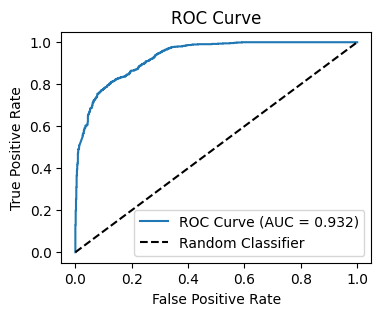


Decision Tree ROC Curve:


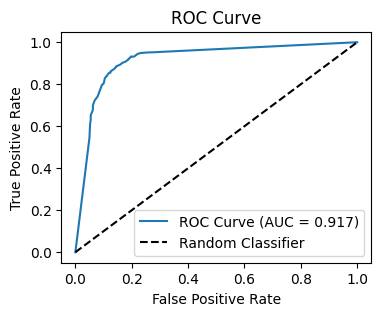


Random Forest ROC Curve:


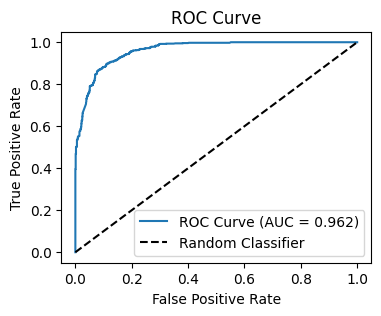


KNN ROC Curve:


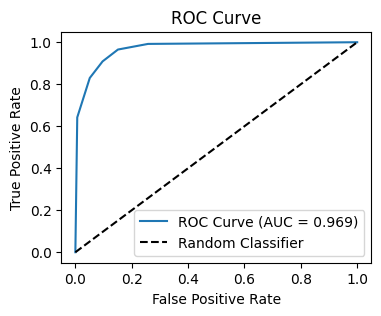


Gaussian NB ROC Curve:


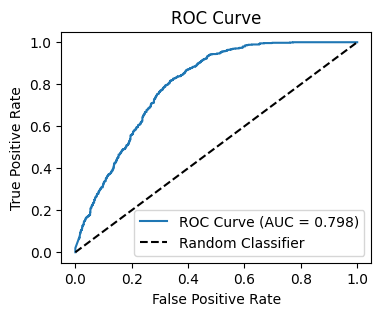


Bernoulli NB ROC Curve:


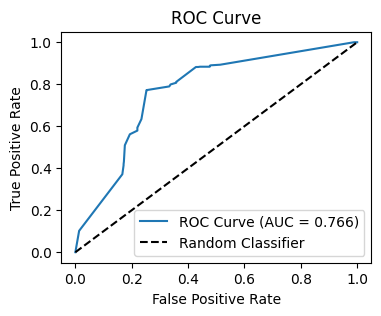

In [12]:

def simple_roc_analysis(model, X_test, y_test):
    """Simple ROC curve analysis"""
    # Get probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    y_test_for_roc = y_test.copy()
    
    # Convert string labels to binary (e.g., 'deciduous' = 1, 'coniferous' = 0)
    y_true = y_test_for_roc.map({'coniferous': 0, 'deciduous': 1}) if isinstance(y_test_for_roc, pd.Series) else y_test_for_roc.apply(lambda x: 1 if x == 'deciduous' else 0)
    
    # Calculate ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return roc_auc

# Plot ROC curve for each model
for name, model in models.items():
    if name != "SVM":  # SVM does not support predict_proba by default
        print(f"\n{name} ROC Curve:")
        simple_roc_analysis(model, X_test, y_test[target_variable])

## Precision-Recall Curves: Focus on the Positive Class

Concept: When you care most about correctly identifying the positive class (especially in imbalanced datasets), precision-recall curves provide more insights than ROC curves by focusing specifically on positive class performance.

We will test if Precision-Recall curves are more informative than ROC curves for our dataset --> The tests shows that ROC curves are sufficient for our relatively balanced dataset.

In [13]:
def choose_curve_type(y_test):
    """Decide which curve is more informative"""
    # Map string labels to binary: 'deciduous' = 1, 'coniferous' = 0
    y_binary = y_test.map({'coniferous': 0, 'deciduous': 1})
    positive_rate = y_binary.mean()
    
    if positive_rate < 0.1:
        return "Use Precision-Recall: Highly imbalanced dataset"
    elif positive_rate < 0.3:
        return "Use both curves: Moderately imbalanced"
    else:
        return "ROC sufficient: Relatively balanced classes"

# Usage
recommendation = choose_curve_type(y_test[target_variable])
print(recommendation)

ROC sufficient: Relatively balanced classes


## Cross-Validation: Reliable Performance Estimation

Concept: Single train-test splits can be misleading due to lucky or unlucky data partitions. Cross-validation provides robust performance estimates by testing your model multiple ways.

In [15]:
def reliable_cv_evaluation(model, X, y):
    """Simple but robust cross-validation"""
    # Use stratified k-fold for balanced splits
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Test multiple metrics
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')
    
    print("Cross-Validation Results:")
    print(f"Accuracy: {accuracy_scores.mean():.3f} ± {accuracy_scores.std():.3f}")
    print(f"F1-Score: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
    
    # Check consistency
    if accuracy_scores.std() > 0.05:
        print("⚠️ High variance - model performance is inconsistent")
    else:
        print("✅ Stable performance across folds")

# Evaluate each model with cross-validation
for name, model in models.items():
    print(f"\n{name} Cross-Validation:")
    reliable_cv_evaluation(model, pd.concat([X_train, X_val]), pd.concat([y_train[target_variable], y_val[target_variable]]))


Logistic Regression Cross-Validation:
Cross-Validation Results:
Accuracy: 0.828 ± 0.008
F1-Score: 0.828 ± 0.007
✅ Stable performance across folds

Decision Tree Cross-Validation:
Cross-Validation Results:
Accuracy: 0.874 ± 0.006
F1-Score: 0.875 ± 0.006
✅ Stable performance across folds

Random Forest Cross-Validation:
Cross-Validation Results:
Accuracy: 0.894 ± 0.006
F1-Score: 0.894 ± 0.006
✅ Stable performance across folds

SVM Cross-Validation:
Cross-Validation Results:
Accuracy: 0.866 ± 0.005
F1-Score: 0.866 ± 0.005
✅ Stable performance across folds

KNN Cross-Validation:
Cross-Validation Results:
Accuracy: 0.919 ± 0.005
F1-Score: 0.919 ± 0.005
✅ Stable performance across folds

Gaussian NB Cross-Validation:
Cross-Validation Results:
Accuracy: 0.712 ± 0.013
F1-Score: 0.710 ± 0.013
✅ Stable performance across folds

Bernoulli NB Cross-Validation:
Cross-Validation Results:
Accuracy: 0.770 ± 0.011
F1-Score: 0.770 ± 0.011
✅ Stable performance across folds


## Error Analysis: Understanding Model Failures

Concept: Systematic error analysis reveals patterns in your model's mistakes, guiding targeted improvements. By understanding what causes errors, you can enhance feature engineering or model selection.

In [19]:
def analyze_errors(model, X_test, y_test):
    """Find patterns in model errors"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Identify errors
    errors = (y_test != y_pred)
    
    print(f"Error Rate: {errors.mean():.3f}")
    print(f"Total Errors: {errors.sum()} / {len(y_test)}")
    
    # Confidence analysis
    max_confidence = y_proba.max(axis=1)
    correct_confidence = max_confidence[~errors].mean()
    error_confidence = max_confidence[errors].mean()
    
    print(f"Average confidence (correct): {correct_confidence:.3f}")
    print(f"Average confidence (errors): {error_confidence:.3f}")
    
    # Low confidence predictions
    low_confidence = max_confidence < 0.6
    print(f"Low confidence predictions: {low_confidence.sum()} ({low_confidence.mean():.1%})")

def feature_error_patterns(X_test, y_test, y_pred, top_features):
    """Analyze how features relate to errors"""
    errors = (y_test != y_pred)
    
    print("Feature Analysis for Errors:")
    for feature in top_features[:3]:  # Top 3 features
        correct_mean = X_test[feature][~errors].mean()
        error_mean = X_test[feature][errors].mean()
        
        print(f"\n{feature}:")
        print(f"  Correct predictions: {correct_mean:.3f}")
        print(f"  Error predictions: {error_mean:.3f}")
        print(f"  Difference: {abs(correct_mean - error_mean):.3f}")

def confidence_strategy(model, X_test, confidence_threshold=0.8):
    """Design confidence-based business strategy"""
    y_proba = model.predict_proba(X_test)
    max_confidence = y_proba.max(axis=1)
    
    high_confidence = max_confidence >= confidence_threshold
    low_confidence = max_confidence < confidence_threshold
    
    print(f"Business Strategy (threshold: {confidence_threshold}):")
    print(f"Auto-process: {high_confidence.sum()} samples ({high_confidence.mean():.1%})")
    print(f"Manual review: {low_confidence.sum()} samples ({low_confidence.mean():.1%})")
    print(f"Workload reduction: {high_confidence.mean():.1%}")

for name, model in models.items():
    if name != "SVM":  # SVM does not support predict_proba by default
        print("\n")
        print("=" * 50)
        print(f"{name} Error Analysis:")
        analyze_errors(model, X_test, y_test[target_variable])
        
        y_pred = model.predict(X_test)
        top_features = X_train.columns.tolist()  # Assuming all features are important for simplicity
        feature_error_patterns(X_test, y_test[target_variable], y_pred, top_features)
        
        confidence_strategy(model, X_test, confidence_threshold=0.8)



Logistic Regression Error Analysis:
Error Rate: 0.163
Total Errors: 268 / 1646
Average confidence (correct): 0.877
Average confidence (errors): 0.693
Low confidence predictions: 153 (9.3%)
Feature Analysis for Errors:

age:
  Correct predictions: 0.018
  Error predictions: -0.201
  Difference: 0.219

average_height:
  Correct predictions: 0.037
  Error predictions: -0.237
  Difference: 0.273

dbh:
  Correct predictions: 0.031
  Error predictions: -0.230
  Difference: 0.262
Business Strategy (threshold: 0.8):
Auto-process: 1128 samples (68.5%)
Manual review: 518 samples (31.5%)
Workload reduction: 68.5%


Decision Tree Error Analysis:
Error Rate: 0.132
Total Errors: 218 / 1646
Average confidence (correct): 0.957
Average confidence (errors): 0.844
Low confidence predictions: 37 (2.2%)
Feature Analysis for Errors:

age:
  Correct predictions: 0.016
  Error predictions: -0.237
  Difference: 0.253

average_height:
  Correct predictions: 0.028
  Error predictions: -0.242
  Difference: 0.27

## Model Calibration: Understanding Prediction Confidence

Concept: Well-calibrated models produce probability estimates that match real-world frequencies. A model saying "80% confident" should be correct about 80% of the time.


Logistic Regression Calibration Check:


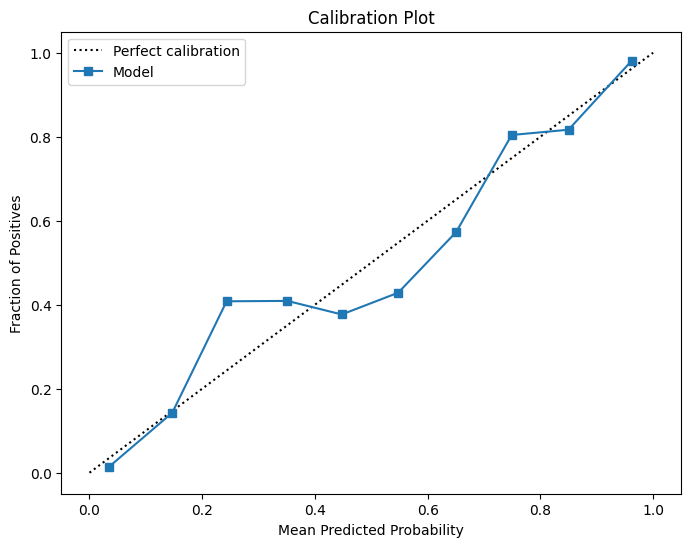

Calibration Error: 0.062
⚠️ Reasonably calibrated

Decision Tree Calibration Check:


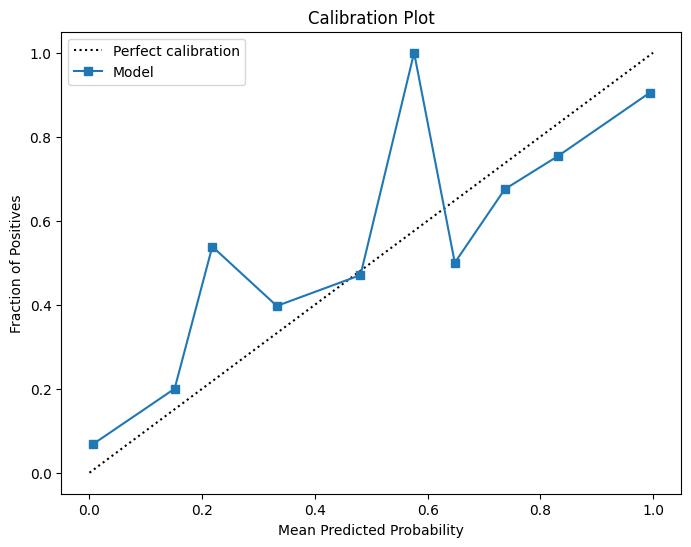

Calibration Error: 0.131
🔴 Poorly calibrated

Random Forest Calibration Check:


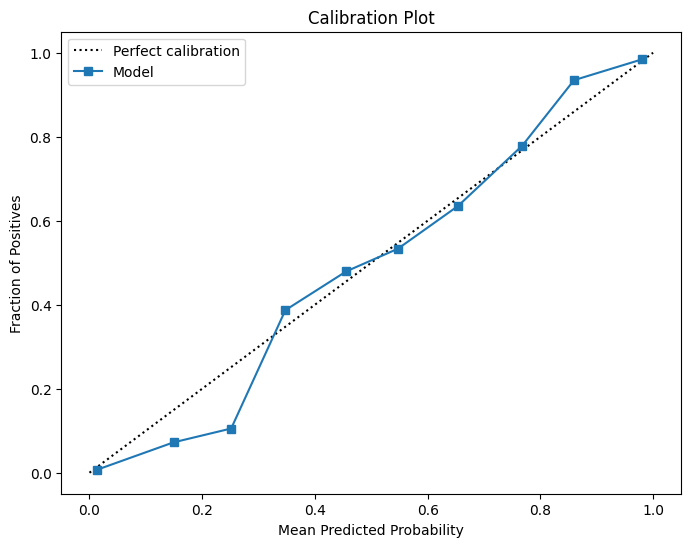

Calibration Error: 0.041
✅ Well calibrated

KNN Calibration Check:


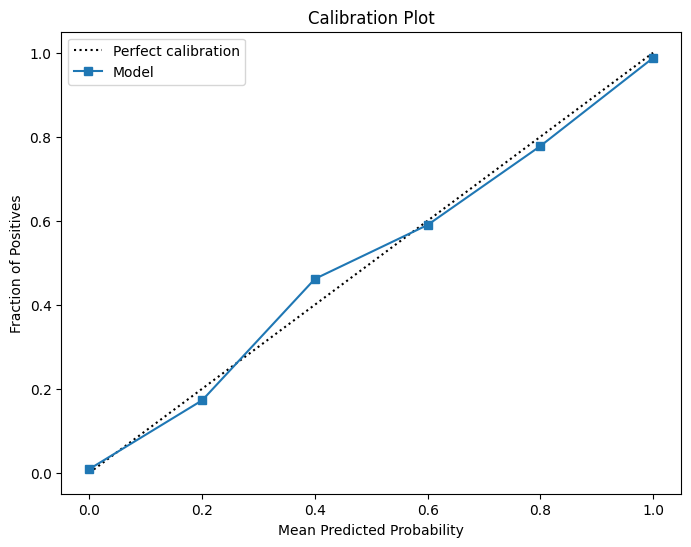

Calibration Error: 0.024
✅ Well calibrated

Gaussian NB Calibration Check:


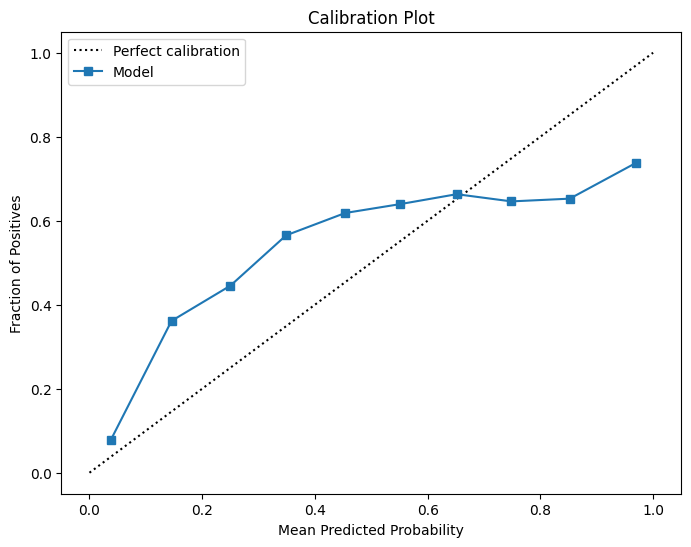

Calibration Error: 0.147
🔴 Poorly calibrated

Bernoulli NB Calibration Check:


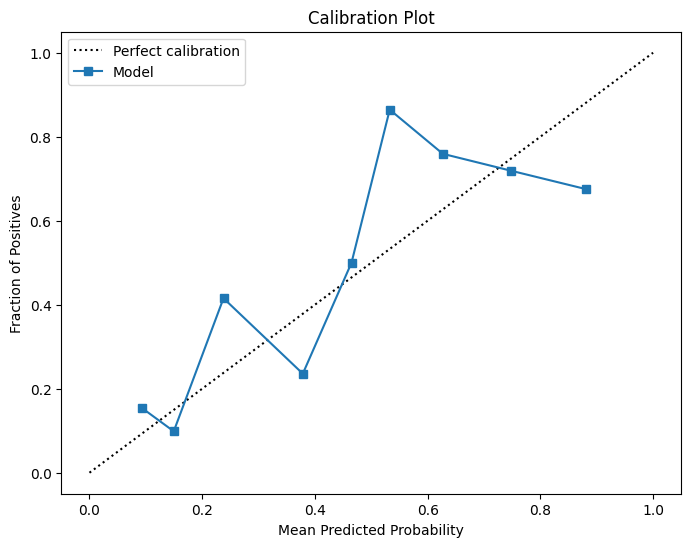

Calibration Error: 0.130
🔴 Poorly calibrated


In [26]:
def check_calibration(model, X_test, y_test):
    """Simple calibration analysis"""
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Convert string labels to binary: 'deciduous' = 1, 'coniferous' = 0
    if isinstance(y_test, pd.DataFrame):
        y_true = y_test.iloc[:, 0].map({'coniferous': 0, 'deciduous': 1})
    else:
        y_true = y_test.map({'coniferous': 0, 'deciduous': 1})
    
    # Calculate calibration
    fraction_positives, mean_predicted = calibration_curve(
        y_true, y_proba, n_bins=10
    )
    
    # Plot calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k:', label='Perfect calibration')
    plt.plot(mean_predicted, fraction_positives, 's-', label='Model')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.show()
    
    # Calculate calibration error
    calibration_error = abs(fraction_positives - mean_predicted).mean()
    print(f"Calibration Error: {calibration_error:.3f}")
    
    if calibration_error < 0.05:
        print("✅ Well calibrated")
    elif calibration_error < 0.1:
        print("⚠️ Reasonably calibrated")
    else:
        print("🔴 Poorly calibrated")

for name, model in models.items():
    if name != "SVM":  # SVM does not support predict_proba by default
        print(f"\n{name} Calibration Check:")
        check_calibration(model, X_test, y_test)

## Business-Aligned Evaluation Metrics

Concept: Technical metrics like accuracy don't always align with business value. Creating custom metrics that reflect real business costs and benefits leads to better model selection decisions.

This is not really relevant for this project, since there are no direct business implications. The key goal is that a third party auditor (like TÜV) accepts the data provided by the model.

## Model Interpretability and Explainability

Concept: Understanding why your model makes specific predictions builds trust and enables better business decisions. Different interpretation methods suit different model types and business needs.

In [30]:
def analyze_feature_importance(model, X_test, feature_names):
    """Extract and analyze feature importance"""
    
    # Method 1: Built-in importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        method = "Built-in importance"
    elif hasattr(model, 'coef_'):
        importance = abs(model.coef_[0])
        method = "Coefficient magnitude"
    else:
        print("Model doesn't have built-in feature importance")
        return None
    
    # Create importance ranking
    feature_importance = list(zip(feature_names, importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    print(f"Feature Importance ({method}):")
    for i, (feature, imp) in enumerate(feature_importance[:10]):
        print(f"{i+1:2d}. {feature}: {imp:.4f}")
    
    return feature_importance

for name, model in models.items():
    print(f"\n{name} Feature Importance:")
    analyze_feature_importance(model, X_test, X_test.columns.tolist())


Logistic Regression Feature Importance:
Feature Importance (Coefficient magnitude):
 1. basal_area: 3.5117
 2. average_height: 2.2833
 3. age: 1.0058
 4. trees_per_ha: 0.8064
 5. dbh: 0.1308

Decision Tree Feature Importance:
Feature Importance (Built-in importance):
 1. basal_area: 0.5488
 2. age: 0.1582
 3. trees_per_ha: 0.1548
 4. average_height: 0.1091
 5. dbh: 0.0291

Random Forest Feature Importance:
Feature Importance (Built-in importance):
 1. basal_area: 0.5296
 2. age: 0.1536
 3. average_height: 0.1156
 4. trees_per_ha: 0.1118
 5. dbh: 0.0894

SVM Feature Importance:
Model doesn't have built-in feature importance

KNN Feature Importance:
Model doesn't have built-in feature importance

Gaussian NB Feature Importance:
Model doesn't have built-in feature importance

Bernoulli NB Feature Importance:
Model doesn't have built-in feature importance


In [39]:
def bootstrap_confidence_intervals(model, X_test, y_test, n_bootstrap=1000):
    """Calculate confidence intervals for performance metrics"""
    
    bootstrap_scores = []
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        X_boot, y_boot = resample(X_test, y_test, random_state=i)
        
        # Calculate metric
        y_pred_boot = model.predict(X_boot)
        score = accuracy_score(y_boot, y_pred_boot)
        bootstrap_scores.append(score)
    
    # Calculate confidence intervals
    confidence_level = 0.95
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_scores, (alpha/2) * 100)
    upper = np.percentile(bootstrap_scores, (1 - alpha/2) * 100)
    mean_score = np.mean(bootstrap_scores)
    
    print(f"Bootstrap Confidence Interval ({confidence_level:.0%}):")
    print(f"Mean Accuracy: {mean_score:.3f}")
    print(f"95% CI: [{lower:.3f}, {upper:.3f}]")
    
    return mean_score, (lower, upper)

for name, model in models.items():
    print(f"\n{name} Bootstrap Confidence Intervals:")
    bootstrap_confidence_intervals(model, X_test, y_test[target_variable], 100)


Logistic Regression Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.838
95% CI: [0.823, 0.857]

Decision Tree Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.873
95% CI: [0.861, 0.889]

Random Forest Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.892
95% CI: [0.879, 0.907]

SVM Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.865
95% CI: [0.845, 0.880]

KNN Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.906
95% CI: [0.895, 0.920]

Gaussian NB Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.711
95% CI: [0.692, 0.732]

Bernoulli NB Bootstrap Confidence Intervals:
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.757
95% CI: [0.739, 0.775]
